In [1]:
import time
# Imports Gunnerus model
from torch_core.simulator.vessels.csad_torch import CSAD_6DOF


# Imports waves
from torch_core.simulator.waves.wave_load_torch import WaveLoad
from torch_core.simulator.waves.wave_spectra_torch import JONSWAP

# Imports utilities
import numpy as np
import math
import torch
import matplotlib.pyplot as plt

# Profiling imports
import cProfile
import pstats
import io

In [2]:
start = time.time()

dt = 0.01
simtime = 100
t = torch.arange(0, simtime, dt)

vessel = CSAD_6DOF(dt=dt, method='RK4')
print(f"Init boat took {time.time() - start:.2f} seconds")

eta = torch.zeros((6, len(t)))
nu = torch.zeros((6, len(t)))
wave_load = torch.zeros((6, len(t)))

Init boat took 0.17 seconds


In [3]:
Uc = 0.0
beta_c = 0

start = time.time()
hs = 5.0/90 # Significant wave height
tp = 9.0*np.sqrt(1/90) # Peak period
gamma = 3.3 # Peak factor
N = 100 

# Discretize freq range
wp = 2.*np.pi / tp
wmin, wmax = wp/2., 3.*wp
dw = (wmax - wmin)/N
w = np.linspace(wmin, wmax, N)


# JONSWAP in PyTorch
jonswap = JONSWAP(w)
freq, spec = jonswap(hs, tp, gamma)  # freq, spec both Tensors

wave_amps = np.sqrt(2.0 * spec.detach().cpu().numpy() * dw)
eps = np.random.uniform(0,2*np.pi, size=N)
wave_dir = np.ones(N) * math.pi/4.0  # Direction of the waves

# DiffWaveLoad expects wave_amps, freqs, eps, angles as NumPy or Torch Tensors
waveload = WaveLoad(
    wave_amps,
    freq.detach().cpu().numpy(),
    eps,
    wave_dir,
    config_file=vessel._config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=True
)
print(f"Init the everything related to the waves took {time.time() - start:.2f} seconds")

Init the everything related to the waves took 0.49 seconds


In [4]:
import torch
import time
import cProfile, pstats, io # Ensure imports are here if cell is run independently
# Assuming CSAD_6DOF, WaveLoad, t, Uc, beta_c, waveload, dt, simtime
# are defined in previous cells.

# Define initial state explicitly for this cell's runs
eta_init = torch.zeros(6, dtype=torch.float32)
nu_init = torch.zeros(6, dtype=torch.float32)

# Define the simulation loop as a function
def run_simulation_loop(vessel, waveload_obj, time_vec, Uc_val, beta_c_val, tau_ctrl):
    num_steps = len(time_vec)
    # Pre-allocate tensors on the same device as vessel state if possible
    # Assuming vessel state (eta, nu) is on CPU by default unless moved
    device = vessel._eta.device # Get device from vessel's tensor (Use _eta)
    eta_hist = torch.zeros((6, num_steps), dtype=torch.float32, device=device)
    nu_hist = torch.zeros((6, num_steps), dtype=torch.float32, device=device)
    wave_load_hist = torch.zeros((6, num_steps), dtype=torch.float32, device=device)

    # Ensure tau_ctrl is on the correct device and dtype
    tau_ctrl = tau_ctrl.to(device=device, dtype=torch.float32)

    for i in range(num_steps):
        current_eta = vessel.get_eta()
        eta_hist[:, i] = current_eta
        nu_hist[:, i] = vessel.get_nu()

        # Calculate wave load - assuming waveload_obj returns a tensor
        tau_wave = waveload_obj(time_vec[i], current_eta)
        # Ensure tau_wave is a tensor on the correct device/dtype
        # (Add assertion or explicit conversion if waveload_obj might return numpy/list)
        if not isinstance(tau_wave, torch.Tensor):
             # Example: Convert if it's numpy, adjust as needed
             tau_wave = torch.tensor(tau_wave, dtype=torch.float32, device=device)
        else:
             tau_wave = tau_wave.to(device=device, dtype=torch.float32)

        wave_load_hist[:, i] = tau_wave

        # Calculate total tau - should result in a float32 tensor
        tau = tau_ctrl + tau_wave

        # Integrate - vessel.integrate should handle the tensor type internally
        vessel.integrate(Uc_val, beta_c_val, tau)

    return eta_hist, nu_hist, wave_load_hist

# --- Simulation Execution ---

# Non-compiled version (for comparison)
print("Starting non-compiled simulation")
vessel_non_compiled = CSAD_6DOF(dt=dt, method='RK4')
vessel_non_compiled.set_eta(eta_init.clone())
vessel_non_compiled.set_nu(nu_init.clone())
tau_control_non_compiled = torch.tensor([0, 0, 0, 0, 0, 0], dtype=torch.float32)

profiler_non_compiled = cProfile.Profile()
start_non_compiled = time.time()
profiler_non_compiled.enable()
eta_non_compiled, nu_non_compiled, wave_load_non_compiled = run_simulation_loop(
    vessel_non_compiled, waveload, t, Uc, beta_c, tau_control_non_compiled
)
profiler_non_compiled.disable()
end_non_compiled = time.time()
non_compiled_time = end_non_compiled - start_non_compiled
print(f"Non-compiled simulation took {non_compiled_time:.2f} seconds")
if non_compiled_time > 0:
    print(f"Simtime/Real: {simtime / non_compiled_time:.2f}")
print("\n--- Non-compiled Profile --- ")
s_non_compiled = io.StringIO()
ps_non_compiled = pstats.Stats(profiler_non_compiled, stream=s_non_compiled).sort_stats('cumulative')
ps_non_compiled.print_stats(20) # Print top 20 functions
print(s_non_compiled.getvalue())

# Compiled version
print("\nStarting compiled simulation")
vessel_compiled = CSAD_6DOF(dt=dt, method='RK4')
vessel_compiled.set_eta(eta_init.clone())
vessel_compiled.set_nu(nu_init.clone())
tau_control_compiled = torch.tensor([0, 0, 0, 0, 0, 0], dtype=torch.float32)

# Compile the entire loop function using 'reduce-overhead' mode
print("Compiling simulation loop function (mode='reduce-overhead')...")
compiled_run_simulation_loop = torch.compile(run_simulation_loop, mode='reduce-overhead')

# Run the compiled function (first run includes compile time)
print("Running compiled function (includes compile time)...")
profiler_compile_run = cProfile.Profile()
start_compile_run = time.time()
profiler_compile_run.enable()
eta_compiled, nu_compiled, wave_load_compiled = compiled_run_simulation_loop(
    vessel_compiled, waveload, t, Uc, beta_c, tau_control_compiled
)
profiler_compile_run.disable()
end_compile_run = time.time()
compile_time = end_compile_run - start_compile_run
print(f"Compiled simulation (including compile time) took {compile_time:.2f} seconds")
print("\n--- Compiled Profile (First Run) --- ")
s_compile_run = io.StringIO()
ps_compile_run = pstats.Stats(profiler_compile_run, stream=s_compile_run).sort_stats('cumulative')
ps_compile_run.print_stats(20) # Print top 20 functions
print(s_compile_run.getvalue())

# Run the compiled function again (should be faster, uses cache)
print("\nRunning compiled function again (cached)...")
# Reset state using a new vessel instance for a clean timing run
vessel_compiled_rerun = CSAD_6DOF(dt=dt, method='RK4')
vessel_compiled_rerun.set_eta(eta_init.clone())
vessel_compiled_rerun.set_nu(nu_init.clone())

profiler_compiled_rerun = cProfile.Profile()
start_compiled_rerun = time.time()
profiler_compiled_rerun.enable()
eta_compiled_rerun, nu_compiled_rerun, wave_load_compiled_rerun = compiled_run_simulation_loop(
    vessel_compiled_rerun, waveload, t, Uc, beta_c, tau_control_compiled
)
profiler_compiled_rerun.disable()
end_compiled_rerun = time.time()
rerun_time = end_compiled_rerun - start_compiled_rerun
print(f"Compiled simulation rerun took {rerun_time:.2f} seconds")
if rerun_time > 0:
    print(f"Simtime/Real (cached): {simtime / rerun_time:.2f}")
else:
    print("Rerun was too fast to measure Simtime/Real accurately.")
print("\n--- Compiled Profile (Cached Run) --- ")
s_compiled_rerun = io.StringIO()
ps_compiled_rerun = pstats.Stats(profiler_compiled_rerun, stream=s_compiled_rerun).sort_stats('cumulative')
ps_compiled_rerun.print_stats(20) # Print top 20 functions
print(s_compiled_rerun.getvalue())

# Store results from the faster (rerun) compiled version for plotting
eta = eta_compiled_rerun
nu = nu_compiled_rerun
wave_load = wave_load_compiled_rerun

Starting non-compiled simulation
Non-compiled simulation took 57.88 seconds
Simtime/Real: 1.73

--- Non-compiled Profile --- 
         6729396 function calls (6689083 primitive calls) in 56.035 seconds

   Ordered by: cumulative time
   List reduced from 368 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   56.063   28.031 /home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
     21/2    0.000    0.000   56.063   28.031 {built-in method builtins.exec}
        1    0.000    0.000   56.063   56.063 /tmp/ipykernel_77034/1567633992.py:61(<module>)
        1    0.811    0.811   56.063   56.063 /tmp/ipykernel_77034/1567633992.py:12(run_simulation_loop)
    10000    0.350    0.000   29.972    0.003 /home/kmroen/projects/McHorcrux/torch_core/simulator/vessels/vessel_torch.py:79(integrate)
    10000    1.802    0.000   29.042    0.003 /home/kmroen/project

/home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/torch/_inductor/lowering.py:1917: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


Compiled simulation (including compile time) took 50.11 seconds

--- Compiled Profile (First Run) --- 
         14756975 function calls (14537542 primitive calls) in 38.896 seconds

   Ordered by: cumulative time
   List reduced from 7298 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   49.178   24.589 /home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
    588/2    0.030    0.000   49.178   24.589 {built-in method builtins.exec}
        1    0.000    0.000   49.178   49.178 /tmp/ipykernel_77034/1567633992.py:92(<module>)
        1    0.000    0.000   49.178   49.178 /home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:619(_fn)
        1    1.547    1.547   48.561   48.561 /tmp/ipykernel_77034/1567633992.py:12(run_simulation_loop)
    10000    0.042    0.000   35.671    0.004 /home/kmroen/miniconda3/envs/t

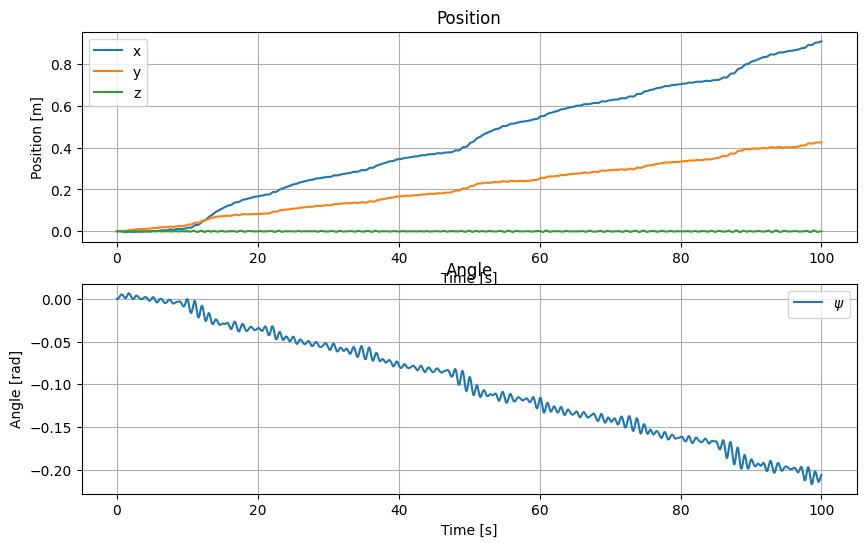

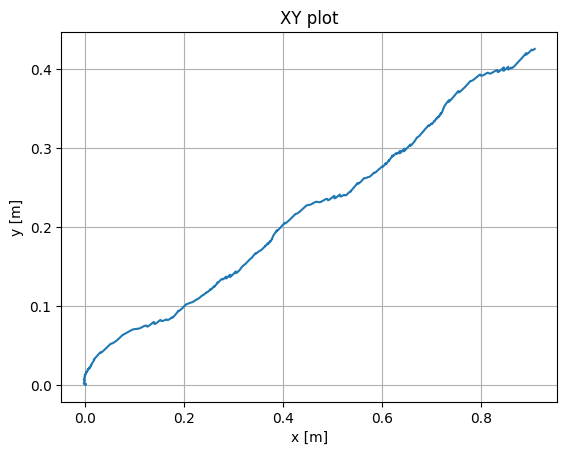

In [5]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(t, eta[0, :], label='x')
axes[0].plot(t, eta[1, :], label='y')
axes[0].plot(t, eta[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t, eta[5, :], label=r"$\psi$")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [rad]')
axes[1].set_title('Angle')

plt.show()


# Plot XY plot to position
plt.figure()
plt.plot(eta[0, :], eta[1, :])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY plot')
plt.show()



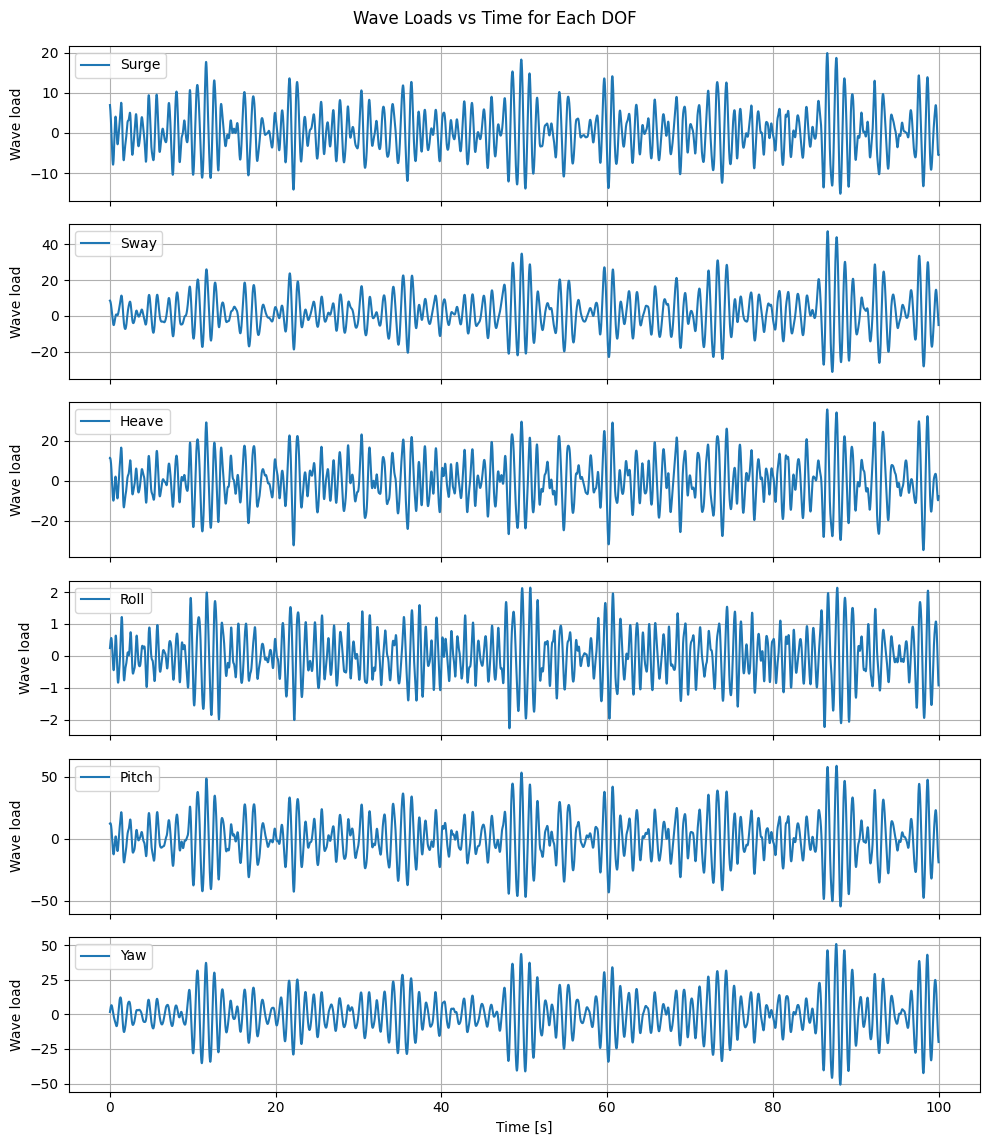

In [6]:
# ----------------------------------------------------------------------------
# Plot the wave loads vs time for each degree of freedom (DOF)
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 12), sharex=True)
dof_labels = ['Surge', 'Sway', 'Heave', 'Roll', 'Pitch', 'Yaw']

for i in range(6):
    axes[i].plot(t, wave_load[i, :], label=f'{dof_labels[i]}')
    axes[i].set_ylabel('Wave load')
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel('Time [s]')
fig.suptitle('Wave Loads vs Time for Each DOF', y=0.95)  # Adjusted y position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()